In [2]:
import torch
import pickle
import torchvision
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from einops import einsum
from diffusers import VQModel
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt
import os
import glob
import random
from PIL import Image
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchinfo

/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Review dataset

In [3]:
image_paths = glob.glob("./CelebAMask-HQ/images/*")
len(image_paths)

30000

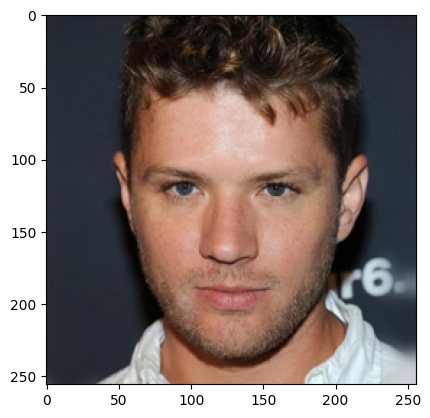

In [10]:
pil_img = Image.open(image_paths[4000])
plt.imshow(pil_img)

In [11]:
pil_img.size

(256, 256)

## VQ VAE

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
vae.eval()
vae = vae.to(device)

In [13]:
torchinfo.summary(vae, input_size=(1, 3,256, 256))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                                       Output Shape              Param #
VQModel                                                      [1, 3, 256, 256]          --
├─Encoder: 1-1                                               [1, 3, 64, 64]            21,594,883
│    └─Conv2d: 2-1                                           [1, 128, 256, 256]        3,584
│    └─ModuleList: 2-26                                      --                        (recursive)
│    │    └─DownEncoderBlock2D: 3-1                          [1, 128, 128, 128]        738,944
├─Decoder: 1-32                                              --                        (recursive)
│    └─UNetMidBlock2D: 2-77                                  --                        (recursive)
│    │    └─ModuleList: 3-79                                 --                        (recursive)
├─Encoder: 1-33                                              --                        (recursive)
│    └─ModuleList: 2-26           

In [14]:
transform_func = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(256),
                torchvision.transforms.ToTensor(),
            ])

In [15]:
transform_func

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    ToTensor()
)

In [16]:
im_tensor = transform_func(pil_img)

# vqvae normalize [-1, 1]
im_tensor = (2 * im_tensor) - 1

# add batch dimension
input_tensor = im_tensor.unsqueeze(0)

input_tensor.shape

torch.Size([1, 3, 256, 256])

In [17]:
with torch.no_grad():
    input_tensor = input_tensor.to(device)
    encoded = vae.encode(input_tensor).latents
    decoded = vae.decode(encoded).sample
    
    # clamp latent vector to [-1, 1]
    encoded = torch.clamp(encoded, -1, 1)
    decoded = torch.clamp(decoded, -1, 1)

    # denormalize 
    encoded = (encoded + 1) / 2
    decoded = (decoded + 1) / 2
    input_tensor = (input_tensor + 1) / 2
    
    # display images
    encoded_grid = make_grid(encoded.cpu(), nrow=1)
    decoded_grid = make_grid(decoded.cpu(), nrow=1)
    input_grid = make_grid(input_tensor.cpu(), nrow=1)

    # visualize
    encoder_grid = torchvision.transforms.ToPILImage()(encoded_grid)
    decoder_grid = torchvision.transforms.ToPILImage()(decoded_grid)
    input_grid = torchvision.transforms.ToPILImage()(input_grid)

In [18]:
input_grid.save('demo/vae_input_samples.png')
encoder_grid.save('demo/vae_encoded_samples.png')
decoder_grid.save('demo/vae_reconstructed_samples.png')

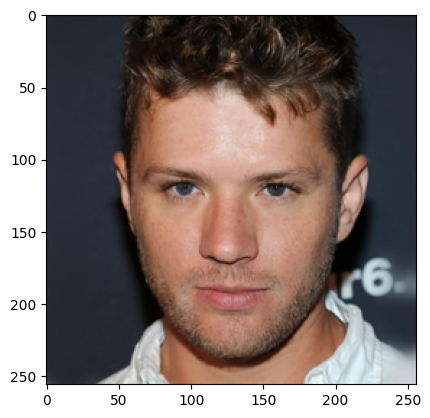

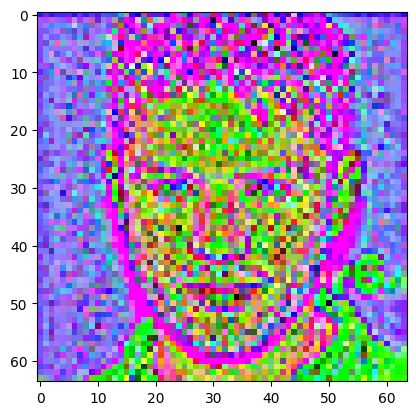

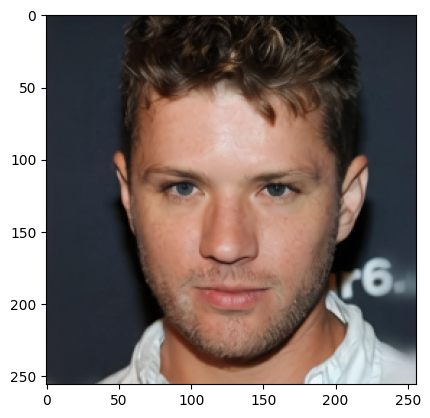

In [19]:
plt.figure()
plt.imshow(input_grid)
plt.figure()
plt.imshow(encoder_grid)
plt.figure()
plt.imshow(decoder_grid)

In [21]:
encoder_grid.size

(64, 64)

In [23]:
decoder_grid.size

(256, 256)

In [24]:
decoded_grid.shape

torch.Size([3, 256, 256])

In [26]:
encoded_grid.shape

torch.Size([3, 64, 64])